# Proyecto Etapa 3: Implementación de Metaheurísticas

**Facultad de ingeniería**

Departamento de Ingeniería de Sistemas y Computación

Universidad de los Andes

**ISIS-3302:** Modelado, Optimización y Simulación

*   Juan Sebastian Ojeda Romero

*   Luisa Gabriela Hernández Pérez

*   Adriana Sofia Rozo Cepeda.

## 1. Implementación de Metaheuristica

### Dependencias

In [17]:
%%capture
%pip install networkx matplotlib
%pip install haversine folium
%pip install seaborn
%python -m amplpy.modules install coin highs scip gcg -q
!apt-get update
!apt-get install -y glpk-utils

In [18]:
!pip install pyomo

### Funciones para calcular las distancias con OSRM o con Haversine

In [19]:
import pandas as pd
from haversine import haversine
import matplotlib.pyplot as plt
from pyomo.environ import *
import pandas as pd
import folium
import requests
import itertools
import requests
from haversine import haversine
from itertools import product
import numpy as np

def get_coordinates(nodo, centros, clientes):
    """
    Devuelve las coordenadas (latitud, longitud) de un nodo, ya sea un centro o un cliente.
    """
    if nodo in centros:
        return centros[nodo]["lat"], centros[nodo]["lon"]
    else:
        return clientes[nodo]["lat"], clientes[nodo]["lon"]


def build_osrm_url(lat1, lon1, lat2, lon2):
    """
    Construye la URL para la consulta a la API pública de OSRM.

    Args:
        lat1, lon1, lat2, lon2 (float): Coordenadas geográficas de los puntos origen y destino.

    Returns:
        str: URL completa para la petición GET.
    """
    base = "http://router.project-osrm.org/route/v1/driving/"
    coords = f"{lon1},{lat1};{lon2},{lat2}"
    return base + coords

def get_route_info(lat1, lon1, lat2, lon2):
    """
    Obtiene información de ruta entre dos puntos usando OSRM.
    Si falla, retorna una distancia geodésica y una línea recta como fallback.

    Args:
        lat1, lon1, lat2, lon2 (float): Coordenadas de los puntos origen y destino.

    Returns:
        tuple: (distancia en km, polilínea de la ruta en formato [[lat, lon], ...])
    """
    url = build_osrm_url(lat1, lon1, lat2, lon2)
    params = {
        "overview": "full",
        "geometries": "geojson"
    }

    fallback_distance = haversine((lat1, lon1), (lat2, lon2))
    return fallback_distance, [[lat1, lon1], [lat2, lon2]]

def calcular_distancias_y_geometrias(centros, clientes, get_route_fn):
    """
    Calcula las distancias y rutas entre todos los pares de nodos válidos,
    usando la función de obtención de ruta especificada.

    Args:
        centros (dict): Diccionario con información de centros de distribución.
        clientes (dict): Diccionario con información de clientes.
        get_route_fn (callable): Función que recibe lat/lon de dos puntos y devuelve (distancia, ruta).

    Returns:
        tuple:
            - distancias: diccionario {(i,j): distancia_km}
            - geometries: diccionario {(i,j): polilínea}
    """
    nodos = list(centros.keys()) + list(clientes.keys())
    distancias = {}
    geometries = {}

    # Recorremos todas las combinaciones de nodos, excepto centro-centro y i == j
    for i, j in product(nodos, repeat=2):
        if i != j and not (i in centros and j in centros):
            lat_i, lon_i = get_coordinates(i, centros, clientes)
            lat_j, lon_j = get_coordinates(j, centros, clientes)

            # Obtener distancia y geometría de ruta
            distancia, ruta = get_route_fn(lat_i, lon_i, lat_j, lon_j)
            distancias[(i, j)] = distancia
            geometries[(i, j)] = ruta

    return distancias, geometries


### Importación de archivos


In [20]:
def import_archives(vehicles,clients,depots):
    vehiculos = pd.read_csv(vehicles)
    municipios = pd.read_csv(clients)
    puertos = pd.read_csv(depots)
    puertos.rename(columns={"Latitude": "tmp", "Longitude": "Latitude", "DepotID": "Longitude", "LocationID": "DepotID"}, inplace=True)
    puertos.drop(columns="tmp", inplace=True)

    num_destinos = municipios.shape[0]
    num_puertos = 1


    puertos_f = {
        f"CD{int(row['DepotID'])}" :{
            "lat": row["Latitude"],
            "lon": row["Longitude"],
        }
        for _, row in puertos.iterrows()
    }

    vehiculos_f = {
        f"V{int(row['VehicleID'])}": {
            "capacidad": row["Capacity"],
            "rango": row["Range"]
        }
        for _, row in vehiculos.iterrows()
    }

    municipios_f = {
        int(row['ClientID']): {
            "demanda": row["Demand"],
            "lat": row["Latitude"],
            "lon": row["Longitude"]
        }
        for _, row in municipios.iterrows()
    }

    distancias, geometries = calcular_distancias_y_geometrias(puertos_f, municipios_f, get_route_info)


    matriz_costos = np.zeros((num_destinos+num_puertos,num_destinos+num_puertos))
    for idx1,idx2 in distancias:
      value = distancias[(idx1,idx2)]
      if idx1 == 'CD1':
        matriz_costos[0,idx2] = value
      elif idx2 == 'CD1':
        matriz_costos[idx1,0] = value
      else:
        matriz_costos[idx1,idx2] = value

    demandas = [0] + municipios["Demand"].tolist()

    rango = vehiculos["Range"].tolist()

    return matriz_costos, demandas, rango, puertos_f, vehiculos_f, municipios_f, distancias, geometries

### Algoritmo Genetico

A continuación se encuentra el código utilizado para resolver el problema con metaheuristica, especificamente con un GA. Para resolver el problema, se utilizó el esqueleto brindado por Juan Andrés Mendez y se modificó en base a las necesidades del problema

Para implementar el CVRP, se tuvieron en cuenta los siguientes cambios para modelarlo correctamente en base al esqueleto:

1.Se añadieron nuevos argumentos a la función __init__, los cuales son:

*   demands: lista que representa las demandas de cada ciudad/cliente
*   vehicle_capacity: numero que representa la capacidad de los vehiculos.
*   vehicle_r: lista que representa la distancia en km que puede recorrer un vehiculo.

2.Se inicializó el argumento possible_capacity para ir guardando una posible mejor combinacion de capacidades para los vehiculos a medida que el algoritmo itera.

3.En _create_random_solution se asigna a cada vehiculo una cantidad aleatoria de recursos que va desde el 70% al 100% de su capacidad máxima original.

4.En evaluate_fitness, se implementan penalizaciones para castigar a los individuos cuyas rutas no satisfacen las demandas de los sitios que visitan, a los que tienen vehiculos cuya capacidad se excedió, y a los que no alcancen a visitar las ciudades de su ruta debido a su rango. Asimismo, tambien se bonifica a aquellos que no infrinjan estas restricciones.

5.Se modifica mutate y sus consecuentes para tener en cuenta que cuando una solucion muta, los recursos que se le asignan a los vehiculos tambien cambian.





Generation 0: Best Fitness = -5970.85, Current Best = -5970.85, Time = 0.16s
Generation 10: Best Fitness = -6027.71, Current Best = -6027.71, Time = 1.42s
Generation 20: Best Fitness = -6130.28, Current Best = -6130.28, Time = 3.29s
Generation 30: Best Fitness = -6158.57, Current Best = -6158.57, Time = 5.16s
Generation 40: Best Fitness = -6167.30, Current Best = -6167.30, Time = 6.93s
Generation 50: Best Fitness = -6167.52, Current Best = -6167.52, Time = 8.61s
Generation 60: Best Fitness = -6170.92, Current Best = -6170.92, Time = 10.17s
Generation 70: Best Fitness = -6173.59, Current Best = -6173.59, Time = 11.72s
Generation 80: Best Fitness = -6174.51, Current Best = -6174.51, Time = 13.60s
Generation 90: Best Fitness = -6184.42, Current Best = -6184.42, Time = 15.33s
Generation 100: Best Fitness = -6184.42, Current Best = -6184.42, Time = 16.89s
Generation 110: Best Fitness = -6184.42, Current Best = -6184.42, Time = 18.67s
Generation 120: Best Fitness = -6202.67, Current Best = -

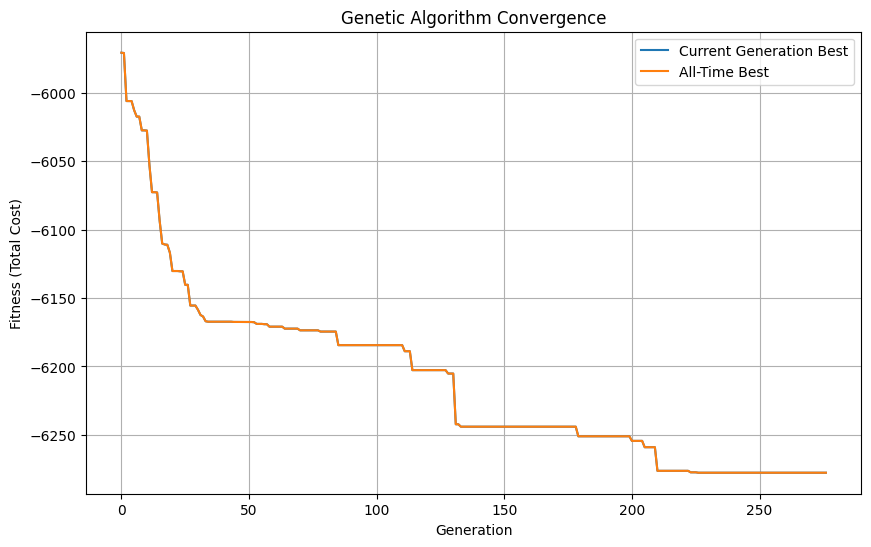

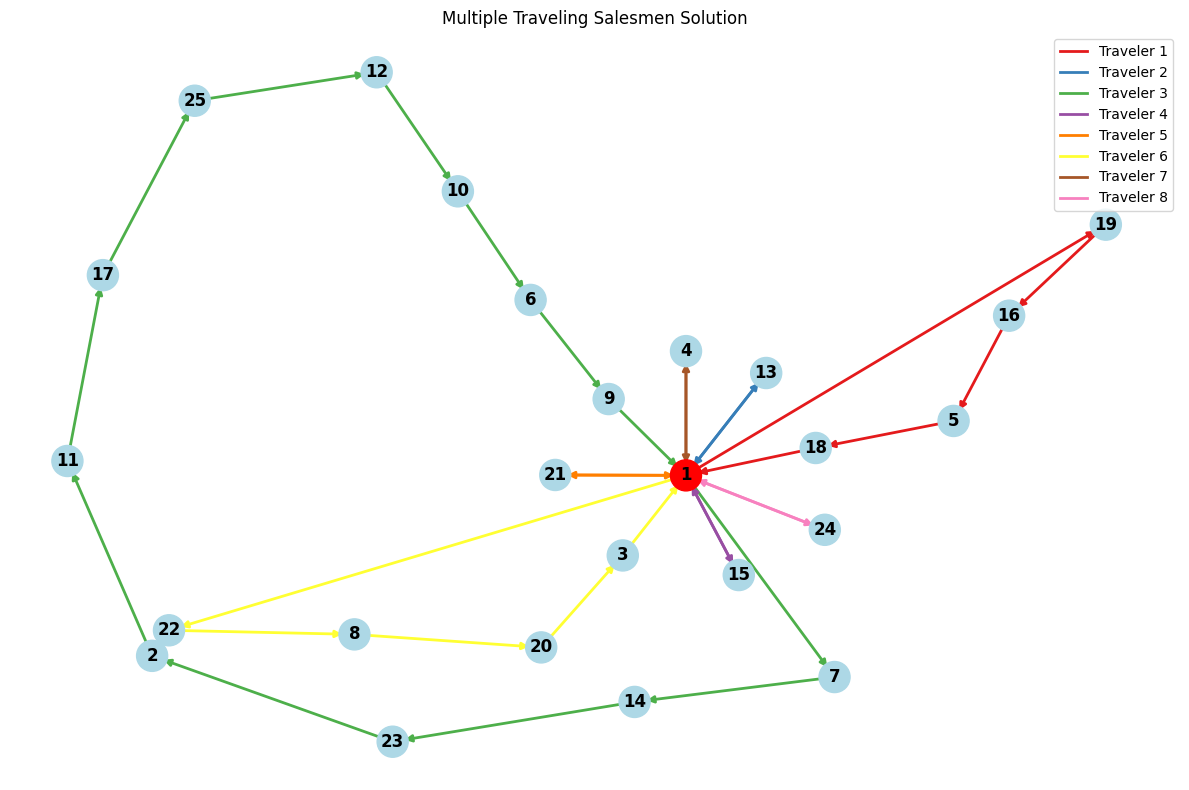

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time
import csv
from collections import defaultdict
from copy import deepcopy

class GeneticAlgorithmMTSP:
    """
    Genetic Algorithm for Multiple Traveling Salesman Problem (MTSP) with multiple depots.

    This implementation uses advanced crossover and mutation operators specifically designed
    for MTSP as recommended in academic literature.
    """

    def __init__(self, cost_matrix, num_cities, num_travelers=3, demands=None, vehicle_capacity=None, vehicle_r = None,depots=None,
                 population_size=100, generations=500, mutation_rate=0.2,
                 crossover_rate=0.8, elitism_rate=0.1, tournament_size=5):
        """
        Initialize the Genetic Algorithm solver.

        Args:
            cost_matrix (np.array): Square matrix of costs between cities
            num_cities (int): Total number of cities including depots
            num_travelers (int): Number of travelers/salesmen
            depots (list): List of depot indices (1-indexed), defaults to [1]
            population_size (int): Size of the population
            generations (int): Maximum number of generations
            mutation_rate (float): Probability of mutation
            crossover_rate (float): Probability of crossover
            elitism_rate (float): Proportion of elite solutions to keep
            tournament_size (int): Size of tournament for selection
        """
        self.cost_matrix = cost_matrix
        self.num_cities = num_cities
        self.num_travelers = num_travelers
        self.demands=demands
        self.vehicle_capacity=vehicle_capacity

        # Default to node 1 if no depots are specified (1-indexed)
        if depots is None:
            self.depots = [1]
        else:
            self.depots = depots

        self.vehicle_r=vehicle_r

        # Create a set of non-depot cities (1-indexed)
        self.non_depots = [i for i in range(1, num_cities + 1) if i not in self.depots]

        # GA parameters
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.tournament_size = tournament_size

        # Results storage
        self.best_solution = None
        self.best_capacity = None
        self.best_fitness = float('inf')
        self.fitness_history = []
        self.best_solution_history = []
        self.population = []
        self.assigned_capacity=[]
        self.possible_capacity=[]

    def initialize_population(self):
        """
        Create an initial population of random solutions.

        Each solution is represented as a list of routes, one for each traveler.
        Each route is a sequence of cities (excluding the depot, which is implicit at start and end).
        """
        population = []
        possible_capacity = []

        for _ in range(self.population_size):
            # Create a random solution
            solution, assigned_capacity = self._create_random_solution()
            population.append(solution)
            possible_capacity.append(assigned_capacity)

        self.population = population
        self.possible_capacity = possible_capacity
        return population, possible_capacity

    def _create_random_solution(self):
        """
        Create a random valid solution.

        Returns:
            List of routes, one per traveler. Each route is a list of cities.
        """
        # Make a copy of non-depot cities that need to be visited
        cities_to_visit = self.non_depots.copy()
        random.shuffle(cities_to_visit)

        # Partition the cities among travelers
        routes = [[] for _ in range(self.num_travelers)]

        # Two strategies: either distribute evenly or randomly
        if random.random() < 0.5:  # Distribute evenly
            cities_per_traveler = len(cities_to_visit) // self.num_travelers
            remainder = len(cities_to_visit) % self.num_travelers

            start_idx = 0
            for i in range(self.num_travelers):
                # Add one extra city to some travelers if there's a remainder
                extra = 1 if i < remainder else 0
                end_idx = start_idx + cities_per_traveler + extra
                routes[i] = cities_to_visit[start_idx:end_idx]
                start_idx = end_idx
        else:  # Distribute randomly but ensure each traveler has at least one city if possible
            min_cities = min(1, len(cities_to_visit) // self.num_travelers)

            # First, ensure minimum cities per traveler
            for i in range(self.num_travelers):
                if len(cities_to_visit) >= min_cities:
                    routes[i] = cities_to_visit[:min_cities]
                    cities_to_visit = cities_to_visit[min_cities:]

            # Then distribute remaining cities randomly
            while cities_to_visit:
                traveler_idx = random.randint(0, self.num_travelers - 1)
                routes[traveler_idx].append(cities_to_visit.pop(0))

        # Optimize each traveler's route with a random 2-opt improvement
        assigned_capacity = []

        for i in range(self.num_travelers):
            assigned_capacity.append(random.randint(int(0.7 * self.vehicle_capacity), self.vehicle_capacity))
            if len(routes[i]) > 3:  # Only worth optimizing if route has enough cities
                routes[i] = self._random_2opt(routes[i])


        return routes, assigned_capacity

    def _random_2opt(self, route, iterations=5):
        """
        Apply a simple 2-opt local search to improve a single route.
        Only performs a few iterations to maintain diversity in the population.
        """
        best_route = route.copy()
        best_cost = self._route_cost(best_route)

        for _ in range(iterations):
            if len(route) < 4:
                break

            # Select random segment to reverse
            i, j = sorted(random.sample(range(len(route)), 2))

            # Apply 2-opt: reverse the segment between i and j
            new_route = best_route[:i] + best_route[i:j+1][::-1] + best_route[j+1:]
            new_cost = self._route_cost(new_route)

            if new_cost < best_cost:
                best_route = new_route
                best_cost = new_cost

        return best_route

    def _route_cost(self, route):
        """Calculate the cost of a single route including return to depot."""
        if not route:  # Empty route
            return 0

        # Default depot is the first one in the list
        depot = self.depots[0]

        # Start at depot, visit all cities in route, return to depot
        cost = self.cost_matrix[depot-1][route[0]-1]  # From depot to first city

        for i in range(len(route) - 1):
            cost += self.cost_matrix[route[i]-1][route[i+1]-1]

        cost += self.cost_matrix[route[-1]-1][depot-1]  # Return to depot
        return cost

    def evaluate_fitness(self, solution, assigned_capacity):
        """Calculate the fitness (total cost) of a solution."""
        total_cost = 0
        penalty_factor = 100
        for i, route in enumerate(solution):
            route_cost = self._route_cost(route)
            demand_per_route = sum(self.demands[city - 1] for city in route)


            # Aumento de fitness por incumplimiento de demanda en la ruta
            if demand_per_route > assigned_capacity[i]:
                total_cost += (demand_per_route - assigned_capacity[i]) * penalty_factor
            else:
                total_cost -= 100


            # Aumento de fitness por inclumplimiento de rango del vehiculo
            if route_cost > self.vehicle_r[i]:
                total_cost += (route_cost - self.vehicle_r[i])*0.5
            else:
                total_cost -= (self.vehicle_r[i] - route_cost) * 3

            if len(route) > 0:
                total_cost -= 300

        num_empty_routes = sum(1 for route in solution if len(route) == 0)
        total_cost += num_empty_routes * 10000


        return total_cost

    def select_parents(self):
        """
        Select parents using tournament selection.

        Returns:
            Two parent solutions
        """
        def tournament():
            participants = random.sample(range(len(self.population)), self.tournament_size)
            participants_fitness = [(p, self.evaluate_fitness(self.population[p], self.possible_capacity[p])) for p in participants]
            winner = min(participants_fitness, key=lambda x: x[1])[0]
            return self.population[winner], self.possible_capacity[winner]

        parent1, cap1 = tournament()
        parent2, cap2 = tournament()
        return parent1, parent2, cap1, cap2

    def crossover(self, parent1, parent2, cap1, cap2):
        """
        Perform crossover between two parents.

        This uses a specialized route-based crossover operator for MTSP:
        1. Route Exchange Crossover - exchanges whole routes between parents
        2. Route Merge Crossover - merges routes between parents and redistributes cities

        Returns:
            Two child solutions
        """
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2), deepcopy(cap1), deepcopy(cap2)

        # Choose crossover type: route exchange or route merge
        if random.random() < 0.5:
            return self._route_exchange_crossover(parent1, parent2, cap1, cap2)
        else:
            return self._route_merge_crossover(parent1, parent2, cap1, cap2)

    def _route_exchange_crossover(self, parent1, parent2, cap1, cap2):
        """
        Route Exchange Crossover: exchanges complete routes between parents.

        This preserves good routes while creating new combinations.
        """
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)

        if self.num_travelers < 2:
            return child1, child2, cap1, cap2

        # Select random routes to exchange
        num_routes_to_exchange = random.randint(1, max(1, self.num_travelers // 2))
        routes_to_exchange = random.sample(range(self.num_travelers), num_routes_to_exchange)

        # Exchange the selected routes
        for route_idx in routes_to_exchange:
            child1[route_idx], child2[route_idx] = child2[route_idx], child1[route_idx]

        # Repair solutions if needed (check for duplicates and missing cities)
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)

        return child1, child2, cap1, cap2

    def _route_merge_crossover(self, parent1, parent2, cap1, cap2):
        """
        Route Merge Crossover: merges corresponding routes, then rebuilds a valid solution.

        This combines parts of routes from both parents, creating more genetic diversity.
        """
        # Collect all cities from both parents (excluding depots)
        all_cities = set(self.non_depots)

        # Create empty routes for children
        child1 = [[] for _ in range(self.num_travelers)]
        child2 = [[] for _ in range(self.num_travelers)]

        # For each traveler's route
        for i in range(self.num_travelers):
            # Choose crossover points for both parents' routes
            if parent1[i] and parent2[i]:
                # Get crossover points
                p1_cross = random.randint(0, len(parent1[i]))
                p2_cross = random.randint(0, len(parent2[i]))

                # Create merged routes (may contain duplicates)
                merged1 = parent1[i][:p1_cross] + parent2[i][p2_cross:]
                merged2 = parent2[i][:p2_cross] + parent1[i][p1_cross:]

                # Keep only the first occurrence of each city
                child1[i] = self._remove_duplicates(merged1)
                child2[i] = self._remove_duplicates(merged2)

        # Repair solutions to ensure all cities are covered
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)

        return child1, child2, cap1, cap2

    def _remove_duplicates(self, route):
        """Remove duplicate cities from a route, keeping the first occurrence."""
        seen = set()
        result = []
        for city in route:
            if city not in seen:
                seen.add(city)
                result.append(city)
        return result

    def _repair_solution(self, solution):
        """
        Repair a solution to ensure all cities are visited exactly once.

        1. Find missing cities (cities that should be visited but aren't in any route)
        2. Find duplicate cities (cities that appear in multiple routes)
        3. Remove duplicates and add missing cities
        """
        # Get all cities in the solution
        included_cities = []
        for route in solution:
            included_cities.extend(route)

        # Find duplicate cities and their positions
        city_counts = defaultdict(list)
        for traveler_idx, route in enumerate(solution):
            for pos, city in enumerate(route):
                city_counts[city].append((traveler_idx, pos))

        # Extract duplicate cities (appearing more than once) and missing cities
        duplicate_cities = {city: positions for city, positions in city_counts.items()
                           if len(positions) > 1}
        missing_cities = [city for city in self.non_depots if city not in included_cities]

        # Process duplicates by keeping the first occurrence and marking others for removal
        to_remove = []
        for city, positions in duplicate_cities.items():
            # Keep the first occurrence, mark others for removal
            for traveler_idx, pos in positions[1:]:
                to_remove.append((traveler_idx, pos))

        # Sort removals in reverse order (to maintain valid indices when removing)
        to_remove.sort(reverse=True)

        # Remove duplicates
        for traveler_idx, pos in to_remove:
            solution[traveler_idx].pop(pos)

        # Distribute missing cities to routes
        random.shuffle(missing_cities)
        for city in missing_cities:
            # Choose a route, preferring those with fewer cities for balance
            route_sizes = [(i, len(route)) for i, route in enumerate(solution)]
            route_idx = min(route_sizes, key=lambda x: x[1])[0]

            # Insert at a random position
            insert_pos = random.randint(0, len(solution[route_idx]))
            solution[route_idx].insert(insert_pos, city)

        return solution

    def mutate(self, solution, capacities):
        """
        Apply mutation operators to the solution.

        Uses several mutation types:
        1. Swap mutation - swaps cities within a route
        2. Insert mutation - moves a city to a different position
        3. Inversion mutation - reverses a segment of a route
        4. Redistribution mutation - moves cities between routes

        Returns:
            Mutated solution
        """
        if random.random() > self.mutation_rate:
            return solution, capacities

        # Choose mutation type
        mutation_type = random.choice(['swap', 'insert', 'invert', 'redistribute'])

        ev = random.uniform(0.1, 1.0)
        if ev > 0.5:
            new_capacity = [cap*1.1 for cap in capacities]
        else:
            new_capacity = [cap*0.9 for cap in capacities]

        if mutation_type == 'swap':
            return self._swap_mutation(solution, new_capacity)
        elif mutation_type == 'insert':
            return self._insert_mutation(solution, new_capacity)
        elif mutation_type == 'invert':
            return self._inversion_mutation(solution, new_capacity)
        else:  # redistribute
            return self._redistribution_mutation(solution, new_capacity)

    def _swap_mutation(self, solution, capacities):
        """Swap two random cities within a random route."""
        mutated = deepcopy(solution)

        # Select a non-empty route
        non_empty_routes = [i for i, route in enumerate(mutated) if len(route) >= 2]
        if not non_empty_routes:
            return mutated, capacities

        route_idx = random.choice(non_empty_routes)
        route = mutated[route_idx]

        # Swap two random positions
        pos1, pos2 = random.sample(range(len(route)), 2)
        route[pos1], route[pos2] = route[pos2], route[pos1]

        return mutated, capacities

    def _insert_mutation(self, solution, capacities):
        """Move a random city to a different position in its route."""
        mutated = deepcopy(solution)

        # Select a non-empty route
        non_empty_routes = [i for i, route in enumerate(mutated) if len(route) >= 2]
        if not non_empty_routes:
            return mutated, capacities

        route_idx = random.choice(non_empty_routes)
        route = mutated[route_idx]

        # Select a city and a new position
        old_pos = random.randint(0, len(route) - 1)
        new_pos = random.randint(0, len(route) - 1)
        while new_pos == old_pos:
            new_pos = random.randint(0, len(route) - 1)

        # Remove city from old position and insert at new position
        city = route.pop(old_pos)
        route.insert(new_pos, city)

        return mutated, capacities

    def _inversion_mutation(self, solution, capacities):
        """Reverse a segment of a random route."""
        mutated = deepcopy(solution)

        # Select a route with enough cities
        eligible_routes = [i for i, route in enumerate(mutated) if len(route) >= 3]
        if not eligible_routes:
            return mutated, capacities

        route_idx = random.choice(eligible_routes)
        route = mutated[route_idx]

        # Select two positions and reverse the segment between them
        pos1, pos2 = sorted(random.sample(range(len(route)), 2))
        mutated[route_idx] = route[:pos1] + route[pos1:pos2+1][::-1] + route[pos2+1:]

        return mutated, capacities

    def _redistribution_mutation(self, solution, assigned_capacity):
        """Move a city from one route to another."""
        mutated = deepcopy(solution)
        capacities = deepcopy(assigned_capacity)

        if self.num_travelers < 2:
            return mutated, capacities

        # Find a non-empty route to take a city from
        non_empty_routes = [i for i, route in enumerate(mutated) if route]
        if not non_empty_routes:
            return mutated, capacities

        from_route_idx = random.choice(non_empty_routes)
        to_route_idx = random.randint(0, self.num_travelers - 1)
        while to_route_idx == from_route_idx:
            to_route_idx = random.randint(0, self.num_travelers - 1)

        # Move a random city from one route to another
        if mutated[from_route_idx]:
            city_pos = random.randint(0, len(mutated[from_route_idx]) - 1)
            city = mutated[from_route_idx].pop(city_pos)

            insert_pos = random.randint(0, len(mutated[to_route_idx]))
            mutated[to_route_idx].insert(insert_pos, city)

            demand = self.demands[city-1]
            capacities[from_route_idx] -= demand
            capacities[to_route_idx] += demand

        return mutated, capacities

    def evolve_population(self):
        """
        Evolve the population to the next generation using elitism, crossover, and mutation.
        """
        # Evaluate current population
        population_fitness = [(i, self.evaluate_fitness(solution,self.possible_capacity[i]))
                              for i, solution in enumerate(self.population)]

        # Sort by fitness (lower is better)
        population_fitness.sort(key=lambda x: x[1])

        # Keep elite solutions
        num_elite = max(1, int(self.elitism_rate * self.population_size))
        elite_indices = [idx for idx, _ in population_fitness[:num_elite]]
        new_population = [deepcopy(self.population[idx]) for idx in elite_indices]
        new_capacities = [deepcopy(self.possible_capacity[idx]) for idx in elite_indices]

        # Fill the rest of the population with offspring
        while len(new_population) < self.population_size:
            # Select parents
            parent1, parent2, cap1, cap2 = self.select_parents()

            # Crossover
            child1, child2, c_cap1, c_cap2 = self.crossover(parent1, parent2, cap1, cap2)

            # Mutation
            child1, c_cap1 = self.mutate(child1, c_cap1)
            child2, c_cap2 = self.mutate(child2, c_cap2)

            # Add to new population
            new_population.append(child1)
            new_capacities.append(c_cap1)
            if len(new_population) < self.population_size:
                new_population.append(child2)
                new_capacities.append(c_cap2)

        self.population = new_population
        self.possible_capacity = new_capacities

    def solve(self, verbose=True, early_stopping_generations=50):
        """
        Run the genetic algorithm to solve the MTSP.

        Args:
            verbose (bool): Whether to print progress information
            early_stopping_generations (int): Stop if no improvement for this many generations

        Returns:
            best_solution, best_fitness
        """
        # Initialize population
        self.initialize_population()

        # Track best solution and convergence
        best_solution = None
        best_capacity = None
        best_fitness = float('inf')
        generations_without_improvement = 0
        start_time = time.time()

        # Main loop
        for generation in range(self.generations):
            # Evolve population
            self.evolve_population()

            # Find best solution in current population
            current_best = None
            current_best_fitness = float('inf')
            current_best_capacity = None

            for i,solution in enumerate(self.population):
                fitness = self.evaluate_fitness(solution,self.possible_capacity[i])
                if fitness < current_best_fitness:
                    current_best = solution
                    current_best_fitness = fitness
                    current_best_capacity = self.possible_capacity[i]

            # Update global best
            if current_best_fitness < best_fitness:
                best_solution = deepcopy(current_best)
                best_fitness = current_best_fitness
                best_capacity = current_best_capacity
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            # Store history
            self.fitness_history.append(current_best_fitness)
            self.best_solution_history.append(best_fitness)

            # Print progress
            if verbose and generation % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}, "
                      f"Current Best = {current_best_fitness:.2f}, "
                      f"Time = {elapsed_time:.2f}s")

            # Early stopping
            if generations_without_improvement >= early_stopping_generations:
                if verbose:
                    print(f"Early stopping at generation {generation} due to no improvement "
                          f"for {early_stopping_generations} generations.")
                break

        # Final results
        self.best_solution = best_solution
        self.best_fitness = best_fitness
        self.best_capacity = best_capacity

        if verbose:
            total_time = time.time() - start_time
            print(f"Optimization complete. Best fitness: {best_fitness:.2f}, "
                  f"Time: {total_time:.2f}s")

        return best_solution, best_fitness

    def plot_convergence(self):
        """Plot the convergence of the genetic algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.fitness_history, label='Current Generation Best')
        plt.plot(self.best_solution_history, label='All-Time Best')
        plt.xlabel('Generation')
        plt.ylabel('Fitness (Total Cost)')
        plt.title('Genetic Algorithm Convergence')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_solution(self):
        """Visualize the best solution found."""
        if not self.best_solution:
            print("No solution to visualize yet. Run solve() first.")
            return

        # Create a directed graph
        G = nx.DiGraph()

        # Add all nodes
        for i in range(1, self.num_cities + 1):
            if i in self.depots:
                G.add_node(i, color='red')  # Depots in red
            else:
                G.add_node(i, color='lightblue')  # Regular cities in blue

        # Add edges for each traveler's route
        edge_colors = plt.cm.Set1.colors
        num_colors = len(edge_colors)

        for traveler_idx, route in enumerate(self.best_solution):
            if not route:
                continue

            # Default depot is the first one in the list
            depot = self.depots[0]

            # Add edge from depot to first city
            G.add_edge(depot, route[0], color=edge_colors[traveler_idx % num_colors],
                       traveler=traveler_idx+1)

            # Add edges between cities
            for i in range(len(route) - 1):
                G.add_edge(route[i], route[i+1], color=edge_colors[traveler_idx % num_colors],
                           traveler=traveler_idx+1)

            # Add edge from last city back to depot
            G.add_edge(route[-1], depot, color=edge_colors[traveler_idx % num_colors],
                       traveler=traveler_idx+1)

        # Position nodes using spring layout
        pos = nx.spring_layout(G, seed=42)

        # Draw the graph
        plt.figure(figsize=(12, 8))

        # Draw nodes
        node_colors = ['red' if i in self.depots else 'lightblue' for i in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)

        # Draw edges with color by traveler
        for (u, v, data) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                   edge_color=[data['color']],
                                   width=2,
                                   arrows=True)

        # Draw labels
        nx.draw_networkx_labels(G, pos, font_weight='bold')

        # Add legend
        legend_elements = [plt.Line2D([0], [0], color=edge_colors[i % num_colors], lw=2,
                                      label=f'Traveler {i+1}')
                          for i in range(self.num_travelers)]
        plt.legend(handles=legend_elements)

        plt.title('Multiple Traveling Salesmen Solution')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def get_solution_details(self):
        """Return detailed information about the best solution."""
        if not self.best_solution:
            return "No solution found yet."

        details = []
        total_cost = 0
        depot = self.depots[0]  # Default to first depot

        details.append("Solution Details:")
        details.append(f"Total Fitness (Cost): {self.best_fitness:.2f}")
        details.append(f"Depot: {depot}")
        details.append("")

        for i, route in enumerate(self.best_solution):
            if not route:
                cost = 0
                details.append(f"Traveler {i+1}: No cities to visit. Cost: {cost:.2f}")
                continue

            route_with_depot = [depot] + route + [depot]
            route_str = " -> ".join(str(city) for city in route_with_depot)

            cost = 0
            for j in range(len(route_with_depot) - 1):
                from_city = route_with_depot[j]
                to_city = route_with_depot[j + 1]
                segment_cost = self.cost_matrix[from_city-1][to_city-1]
                cost += segment_cost

            total_cost += cost
            details.append(f"Traveler {i+1}: {route_str}. Cost: {cost:.2f}")

        details.append("")
        details.append(f"Total Cost: {total_cost:.2f}")

        return "\n".join(details)


def read_cost_matrix_csv(filename):
    """
    Reads a cost matrix from a CSV file.

    The first row of the CSV is assumed to contain the node IDs.

    Parameters:
        filename (str): The name of the CSV file.

    Returns:
        cost_matrix (np.array): A 2D numpy array representing the cost matrix.
    """
    with open(filename, 'r', newline='') as file:
        reader = csv.reader(file)

        # Skip the header row with node IDs
        next(reader)

        data = list(reader)

    cost_matrix = np.array(data, dtype=float)

    return cost_matrix


# Example usage
if __name__ == "__main__":
    v = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/base-case/vehicles.csv'
    c = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/base-case/clients.csv'
    d = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/base-case/depots.csv'
    res = import_archives(v,c,d)
    cost_matrix = res[0]
    num_cities = len(cost_matrix)
    num_travelers = len(res[4].values())
    depots = [1]  # 1-indexed
    vehicle_r=res[2]
    demands = res[1]

    # Create and run the genetic algorithm
    ga = GeneticAlgorithmMTSP(
        cost_matrix=cost_matrix,
        num_cities=num_cities,
        num_travelers=num_travelers,
        demands=demands,
        vehicle_capacity = 130,
        vehicle_r=vehicle_r,
        depots=depots,
        population_size=500,
        generations=500,
        mutation_rate=0.25,
        crossover_rate=0.8,
        elitism_rate=0.02,
        tournament_size=5
    )

    # Solve the problem
    best_solution, best_fitness = ga.solve(verbose=True)

    # Print detailed solution
    print(ga.get_solution_details())

    # Plot results
    ga.plot_convergence()
    ga.plot_solution()

## **Comparación** **con Pyomo**

Primero, evaluaremos la eficiencia usando la implementación del caso base en pyomo.

In [31]:
import requests
from haversine import haversine
from itertools import product

def get_coordinates(nodo, centros, clientes):
    """
    Devuelve las coordenadas (latitud, longitud) de un nodo, ya sea un centro o un cliente.
    """
    if nodo in centros:
        return centros[nodo]["lat"], centros[nodo]["lon"]
    else:
        return clientes[nodo]["lat"], clientes[nodo]["lon"]


def build_osrm_url(lat1, lon1, lat2, lon2):
    """
    Construye la URL para la consulta a la API pública de OSRM.

    Args:
        lat1, lon1, lat2, lon2 (float): Coordenadas geográficas de los puntos origen y destino.

    Returns:
        str: URL completa para la petición GET.
    """
    base = "http://router.project-osrm.org/route/v1/driving/"
    coords = f"{lon1},{lat1};{lon2},{lat2}"
    return base + coords

def get_route_info(lat1, lon1, lat2, lon2):
    """
    Obtiene información de ruta entre dos puntos usando OSRM.
    Si falla, retorna una distancia geodésica y una línea recta como fallback.

    Args:
        lat1, lon1, lat2, lon2 (float): Coordenadas de los puntos origen y destino.

    Returns:
        tuple: (distancia en km, polilínea de la ruta en formato [[lat, lon], ...])
    """
    
    fallback_distance = haversine((lat1, lon1), (lat2, lon2))
    return fallback_distance, [[lat1, lon1], [lat2, lon2]]

def calcular_distancias_y_geometrias(centros, clientes, get_route_fn):
    """
    Calcula las distancias y rutas entre todos los pares de nodos válidos,
    usando la función de obtención de ruta especificada.

    Args:
        centros (dict): Diccionario con información de centros de distribución.
        clientes (dict): Diccionario con información de clientes.
        get_route_fn (callable): Función que recibe lat/lon de dos puntos y devuelve (distancia, ruta).

    Returns:
        tuple: 
            - distancias: diccionario {(i,j): distancia_km}
            - geometries: diccionario {(i,j): polilínea}
    """
    nodos = list(centros.keys()) + list(clientes.keys())
    distancias = {}
    geometries = {}

    # Recorremos todas las combinaciones de nodos, excepto centro-centro y i == j
    for i, j in product(nodos, repeat=2):
        if i != j and not (i in centros and j in centros):
            lat_i, lon_i = get_coordinates(i, centros, clientes)
            lat_j, lon_j = get_coordinates(j, centros, clientes)

            # Obtener distancia y geometría de ruta
            distancia, ruta = get_route_fn(lat_i, lon_i, lat_j, lon_j)
            distancias[(i, j)] = distancia
            geometries[(i, j)] = ruta

    return distancias, geometries

import folium

def visualizar_rutas_folium(model, puertos, municipios, geometries, colores_vehiculos=None,
                             nombre_archivo="./resultados/ruta_optima_nacional.html"):
    """
    Visualiza las rutas óptimas obtenidas por el modelo de optimización usando un mapa de Folium.

    Args:
        model (ConcreteModel): Modelo de Pyomo con variables x[i,j,v] que indican rutas utilizadas por vehículo.
        puertos (dict): Diccionario con coordenadas de los puertos. Ej: { 'P1': {'lat': .., 'lon': ..}, ... }
        municipios (dict): Diccionario con coordenadas de los municipios (clientes). Mismo formato que puertos.
        geometries (dict): Diccionario con las rutas reales entre pares (i, j), en formato [[lat, lon], ...]
        colores_vehiculos (dict, optional): Colores por vehículo para diferenciar rutas. Ej: { 'V1': 'red' }
        nombre_archivo (str): Ruta donde se guardará el archivo HTML generado.

    Returns:
        None. Guarda un archivo HTML interactivo y lo notifica por consola.
    """
    if colores_vehiculos is None:
        colores_vehiculos = {}

    # === Centro del mapa: promedio de coordenadas ===
    all_coords = [(puertos[n]["lat"], puertos[n]["lon"]) for n in puertos] + \
                 [(municipios[n]["lat"], municipios[n]["lon"]) for n in municipios]
    mean_lat = sum(lat for lat, _ in all_coords) / len(all_coords)
    mean_lon = sum(lon for _, lon in all_coords) / len(all_coords)

    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)

    # === Marcadores para puertos ===
    for p in puertos:
        folium.Marker(
            location=[puertos[p]["lat"], puertos[p]["lon"]],
            popup=f"Puerto {p}",
            icon=folium.Icon(color='green', icon='ship', prefix='fa')
        ).add_to(m)

    # === Marcadores para municipios ===
    for mnp in municipios:
        folium.Marker(
            location=[municipios[mnp]["lat"], municipios[mnp]["lon"]],
            popup=f"Municipio {mnp}",
            icon=folium.Icon(color='blue', icon='user', prefix='fa')
        ).add_to(m)

    # === Dibujar rutas utilizadas por vehículos ===
    for v in model.V:
        for (i, j) in model.A:
            var = model.x[i, j, v]
            if var.value is not None and var.value > 0.5:
                polyline = geometries.get((i, j))
                if polyline:
                    folium.PolyLine(
                        locations=polyline,
                        color=colores_vehiculos.get(v, 'black'),
                        weight=5,
                        opacity=0.8,
                        popup=f"Ruta {i} → {j} (Vehículo {v})"
                    ).add_to(m)

    # === Guardar el resultado ===
    m.save(nombre_archivo)
    print(f"El mapa de rutas ha sido guardado en '{nombre_archivo}'.")

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

def visualizar_rutas_estatica(model, puertos, municipios, geometries,
                               colores_vehiculos=None,
                               titulo="Rutas Nacionales",
                               ruta_salida="../visual-results/mapa_estatico_caso1.png"):
    """
    Visualización estática con matplotlib de las rutas asignadas por el modelo.

    Args:
        model: Modelo Pyomo con variables x[i,j,v].
        puertos (dict): Diccionario con lat/lon de puertos.
        municipios (dict): Diccionario con lat/lon de municipios.
        geometries (dict): Diccionario de polilíneas [(lat, lon)] por arco (i,j).
        colores_vehiculos (dict): Colores por ID de vehículo.
        titulo (str): Título del gráfico.
        ruta_salida (str): Ruta donde guardar la imagen PNG.
    """
    if colores_vehiculos is None:
        colores_vehiculos = {}

    os.makedirs(os.path.dirname(ruta_salida), exist_ok=True)

    plt.figure(figsize=(10, 10))

    # === Dibujar nodos: puertos
    for p_id, p in puertos.items():
        plt.plot(p['lon'], p['lat'], 's', color='green', markersize=10)
        plt.text(p['lon'], p['lat'] + 0.02, p_id, fontsize=9, ha='center')

    # === Dibujar nodos: municipios
    for c_id, c in municipios.items():
        plt.plot(c['lon'], c['lat'], 'o', color='blue', markersize=6)
        plt.text(c['lon'], c['lat'] + 0.015, c_id, fontsize=8, ha='center')

    # === Dibujar rutas por vehículo
    for v in model.V:
        color = colores_vehiculos.get(v, 'black')
        for (i, j) in model.A:
            if model.x[i, j, v].value is not None and model.x[i, j, v].value > 0.5:
                polyline = geometries.get((i, j))
                if polyline:
                    lats, lons = zip(*polyline)
                    plt.plot(lons, lats, '-', color=color, linewidth=2, alpha=0.8)

    # === Leyenda profesional con colores reales
    leyenda = [
        Line2D([0], [0], color=colores_vehiculos.get(v, 'black'), lw=3, label=f'Vehículo {v}')
        for v in model.V
    ]
    plt.legend(handles=leyenda, title='Vehículos', loc='best', fontsize=8)

    # === Estética y guardado
    plt.title(titulo)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(ruta_salida, dpi=300)
    plt.show()
    print(f"Mapa estático guardado en: {ruta_salida}")

from pyomo.environ import *

class ModeloCasoBase:
    def __init__(self, puertos, municipios, vehiculos, parametros, distancias):
        self.puertos = puertos
        self.municipios = municipios
        self.vehiculos = vehiculos
        self.parametros = parametros
        self.distancias = distancias
        self.model = ConcreteModel()
        self._build_model()
        
    def _build_model(self):
        model = self.model
        puertos = self.puertos
        municipios = self.municipios
        vehiculos = self.vehiculos
        distancias = self.distancias
        nodos = list(puertos.keys()) + list(municipios.keys())
        
        # === Conjuntos ===
        model.N = Set(initialize=nodos)  
        model.M = Set(initialize=municipios.keys())  
        model.P = Set(initialize=puertos.keys()) 
        model.V = Set(initialize=list(vehiculos.keys()))
        model.A = Set(
            within=(model.P | model.M) * (model.P | model.M),
            initialize=[(i, j) for i in (set(puertos.keys()) | set(municipios.keys()))
                        for j in (set(puertos.keys()) | set(municipios.keys()))
                        if i != j and not (i in puertos and j in puertos)]
        )

        
        # === Parámetros ===
        model.dem_m = Param(model.M, initialize={m: municipios[m]["demanda"] for m in model.M})
        model.dist_ij = Param(model.A, initialize=distancias)
        model.cap_v = Param(model.V, initialize={v: vehiculos[v]["capacidad"] for v in vehiculos})
        model.rango_v = Param(model.V, initialize={v: vehiculos[v]["rango"] for v in vehiculos})

        # === Variables ===
        model.x = Var(model.A, model.V, within=Binary) 
        model.u = Var(model.M, model.V, within=NonNegativeIntegers, bounds=(0, len(model.M | model.P) - 1))

        
        # === Función Objetivo ===
        def funcion_objetivo(model):
            return sum(
                model.x[i, j, v] * model.dist_ij[i, j] *
                (self.parametros["ft"] + self.parametros["m"] + self.parametros["tk"] * self.parametros["fi"])
                for v in model.V for (i, j) in model.A
            )

        model.objetivo = Objective(rule=funcion_objetivo, sense=minimize)

        
        # === Restricciones ===

        def capacidad_vehiculos_rule(model, v):
            return sum(model.x[i, m, v] * model.dem_m[m] for (i, m) in model.A if m in model.M) <= model.cap_v[v]
        model.capacidad_vehiculos = Constraint(model.V, rule=capacidad_vehiculos_rule)

        def visitar_municipios_rule(model, m):
            return sum(model.x[i, m, v] for v in model.V for i in nodos if (i, m) in model.A) == 1
        model.visitar_municipios = Constraint(model.M, rule=visitar_municipios_rule)

        def autonomia_vehiculos_rule(model, v):
            return sum(model.dist_ij[i, j] * model.x[i, j, v] for (i, j) in model.A) <= model.rango_v[v]
        model.autonomia_vehiculos = Constraint(model.V, rule=autonomia_vehiculos_rule)

        def conservacion_flujo_rule(model, i, v):
            salida = sum(model.x[i, j, v] for j in nodos if (i, j) in model.A)
            entrada = sum(model.x[j, i, v] for j in nodos if (j, i) in model.A)
            return salida - entrada == 0 if i in model.M else salida - entrada <= 1
        model.conservacion_flujo = Constraint(nodos, model.V, rule=conservacion_flujo_rule)

        def subtours_elimination_rule(model, i, j, v):
            if i != j and i in model.M and j in model.M:
                return model.u[i, v] - model.u[j, v] + len(nodos) * model.x[i, j, v] <= len(nodos) - 1
            else:
                return Constraint.Skip
        model.subtours_elimination = Constraint(model.M, model.M, model.V, rule=subtours_elimination_rule)

        def salida_unica_rule(model, v):
            return sum(model.x[p, j, v] for p in model.P for j in model.M if (p, j) in model.A) == 1
        model.salida_unica = Constraint(model.V, rule=salida_unica_rule)

        def retorno_puerto_rule(model, v):
            return sum(model.x[i, p, v] for p in model.P for i in model.M if (i, p) in model.A) >= 1
        model.retorno_puerto = Constraint(model.V, rule=retorno_puerto_rule)


    def solve(self, solver_name="glpk"):
        solver = SolverFactory(solver_name)
        return solver.solve(self.model, options={'tmlim': 450})
    
    def print_routes(self):
        model = self.model
        print("Asignaciones ordenadas por vehículo:\n")
        
        for v in model.V:
            salida = [(i, j) for (i, j) in model.A
                    if i in model.P and model.x[i, j, v].value == 1]
            
            if not salida:
                print(f"Vehículo {v}: no sale de ningún puerto")
                continue

            start_arc = salida[0]
            ruta = [start_arc[0]]
            actual = start_arc[1]
            ruta.append(actual)

            while actual not in model.P:
                siguiente = next(
                    (j for (i, j) in model.A if i == actual and model.x[i, j, v].value == 1),
                    None
                )
                if siguiente is None:
                    break
                ruta.append(siguiente)
                actual = siguiente

            print(f"Vehículo {v}:")
            for u, w in zip(ruta, ruta[1:]):
                print(f"  - {u} -> {w}")
            print()
    def model_status(self):
        return self.model.display()
    

import pandas as pd
vehiculos = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/base-case/vehicles.csv')
municipios = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/base-case/clients.csv')
puertos = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/base-case/depots.csv')
puertos.rename(columns={"Latitude": "tmp", "Longitude": "Latitude", "DepotID": "Longitude", "LocationID": "DepotID"}, inplace=True)
puertos.drop(columns="tmp", inplace=True)

from IPython.display import display, HTML

puertos_f = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
    }
    for _, row in puertos.iterrows()
}

vehiculos_f = {
    f"V{int(row['VehicleID'])}": {
        "capacidad": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehiculos.iterrows()
}

municipios_f = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in municipios.iterrows()
}

parametros = {"fi": 12, "ft": 5000, "m": 700, "tk": 1}
distancias, geometries = calcular_distancias_y_geometrias(puertos_f, municipios_f, get_route_info)
print(distancias)
modelo2 = ModeloCasoBase(puertos_f, municipios_f, vehiculos_f, parametros, distancias)
modelo2.solve()
modelo2.print_routes()

{('CD1', 'C1'): 17.263444271536358, ('CD1', 'C2'): 10.620126894924754, ('CD1', 'C3'): 6.377821224493921, ('CD1', 'C4'): 16.597119606502737, ('CD1', 'C5'): 10.62340219677577, ('CD1', 'C6'): 9.731264593168408, ('CD1', 'C7'): 15.429106593606146, ('CD1', 'C8'): 10.646038973434123, ('CD1', 'C9'): 15.241861000422377, ('CD1', 'C10'): 21.83131006314039, ('CD1', 'C11'): 17.092320203996398, ('CD1', 'C12'): 5.9418667697568335, ('CD1', 'C13'): 12.492367239367232, ('CD1', 'C14'): 4.004799058951106, ('CD1', 'C15'): 16.81224493507039, ('CD1', 'C16'): 21.207358840856593, ('CD1', 'C17'): 14.533472573067701, ('CD1', 'C18'): 10.188306488493257, ('CD1', 'C19'): 12.205155509363443, ('CD1', 'C20'): 3.5281280083252256, ('CD1', 'C21'): 14.297882611185877, ('CD1', 'C22'): 15.05349236869324, ('CD1', 'C23'): 4.311182695121169, ('CD1', 'C24'): 18.68931048602902, ('C1', 'CD1'): 17.263444271536358, ('C1', 'C2'): 10.322829244377342, ('C1', 'C3'): 12.435540914538525, ('C1', 'C4'): 0.807864838873722, ('C1', 'C5'): 9.1

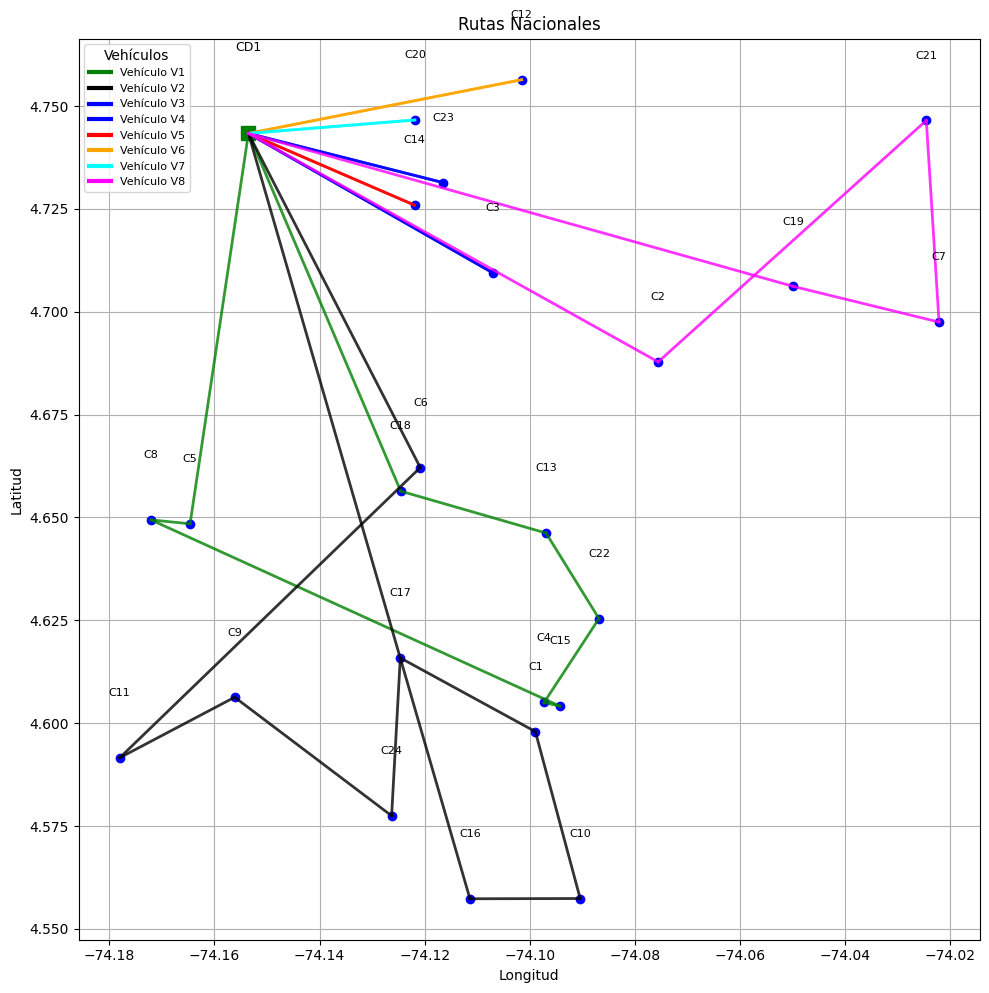

Mapa estático guardado en: ../visual-results/mapa_estatico_caso1.png


In [32]:
colores1 = {
    'V1': 'green',
    'V2': 'black',
    'V3': 'blue',
    'V4': 'blue',
    'V5': 'red',
    'V6': 'orange',
    'V7': 'cyan',
    'V8': 'magenta',
}
visualizar_rutas_estatica(modelo2.model, puertos_f, municipios_f, geometries, colores1)

Generation 0: Best Fitness = 54605.05, Current Best = 54605.05, Time = 0.10s
Generation 10: Best Fitness = 51575.52, Current Best = 51575.52, Time = 1.04s
Generation 20: Best Fitness = 51574.53, Current Best = 51574.53, Time = 1.96s
Generation 30: Best Fitness = 51572.40, Current Best = 51572.40, Time = 2.84s
Generation 40: Best Fitness = 51572.40, Current Best = 51572.40, Time = 3.74s
Generation 50: Best Fitness = 51572.40, Current Best = 51572.40, Time = 4.73s
Generation 60: Best Fitness = 51572.40, Current Best = 51572.40, Time = 5.63s
Generation 70: Best Fitness = 51572.40, Current Best = 51572.40, Time = 6.35s
Early stopping at generation 71 due to no improvement for 50 generations.
Optimization complete. Best fitness: 51572.40, Time: 6.43s
Solution Details:
Total Fitness (Cost): 51572.40
Depot: 1

Traveler 1: 1 -> 2 -> 5 -> 1. Cost: 20120.36
Traveler 2: No cities to visit. Cost: 0.00
Traveler 3: No cities to visit. Cost: 0.00
Traveler 4: 1 -> 3 -> 1. Cost: 20109.91
Traveler 5: 1 

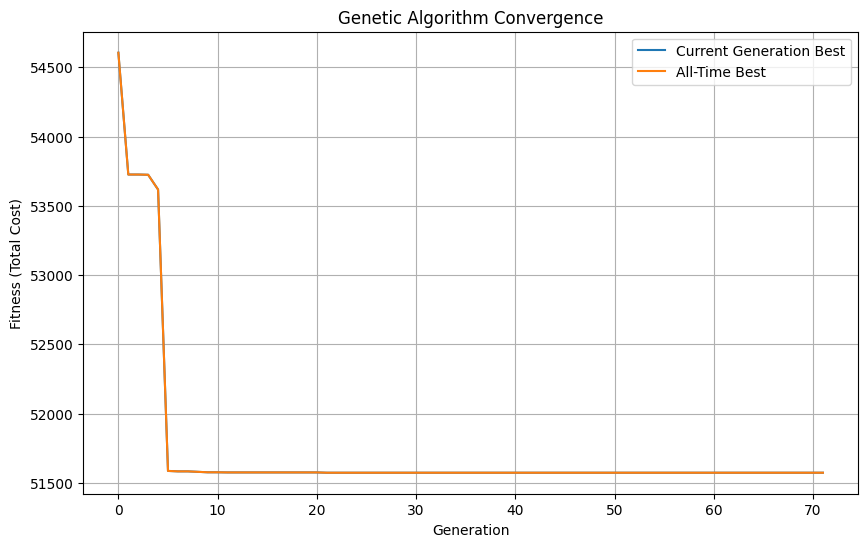

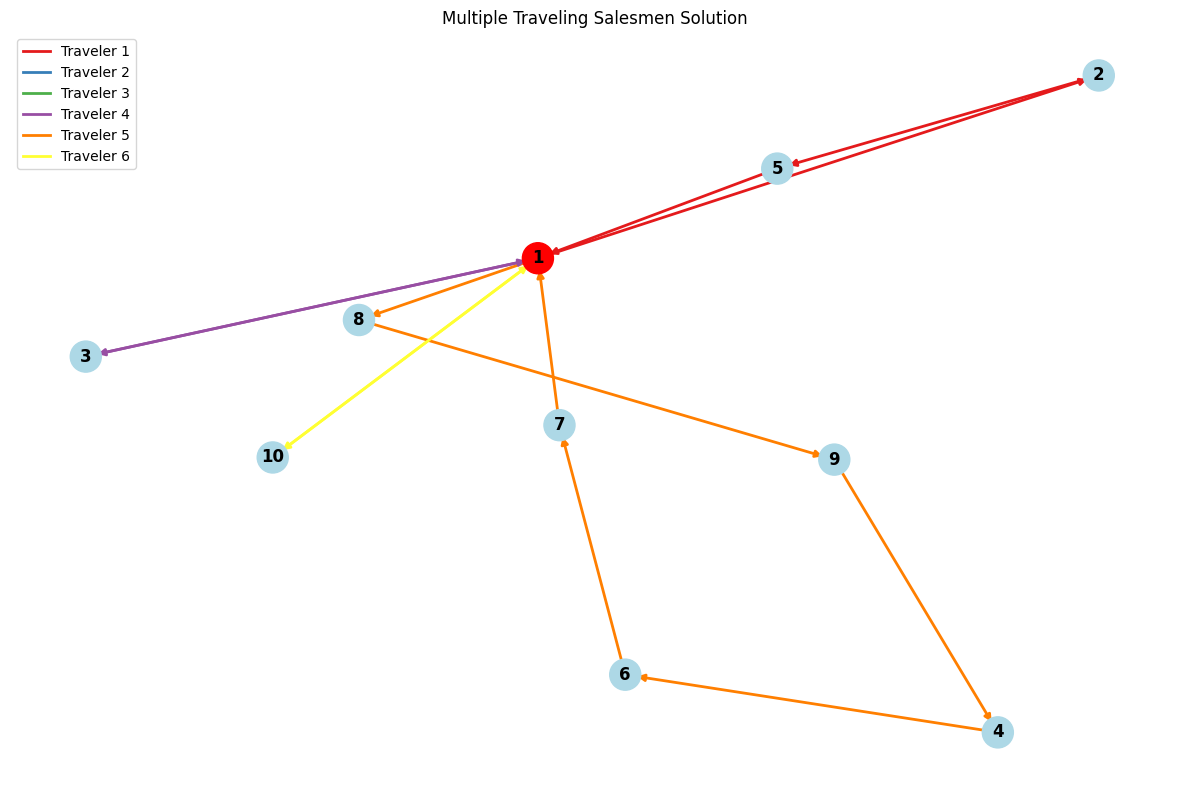

In [24]:
if __name__ == "__main__":
    v = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case2/vehicles.csv'
    c = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case2/clients.csv'
    d = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case2/depots.csv'
    res = import_archives(v,c,d)
    cost_matrix = res[0]
    num_cities = len(cost_matrix)
    num_travelers = len(res[4].values())
    depots = [1]  # 1-indexed
    vehicle_r=res[2]
    demands = res[1]

    # Create and run the genetic algorithm
    ga = GeneticAlgorithmMTSP(
        cost_matrix=cost_matrix,
        num_cities=num_cities,
        num_travelers=num_travelers,
        demands=demands,
        vehicle_capacity = 130,
        vehicle_r=vehicle_r,
        depots=depots,
        population_size=500,
        generations=500,
        mutation_rate=0.25,
        crossover_rate=0.8,
        elitism_rate=0.02,
        tournament_size=5
    )

    # Solve the problem
    best_solution, best_fitness = ga.solve(verbose=True)

    # Print detailed solution
    print(ga.get_solution_details())

    # Plot results
    ga.plot_convergence()
    ga.plot_solution()

In [25]:
vehiculos = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case2/vehicles.csv')
municipios = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case2/clients.csv')
puertos = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case2/depots.csv')
puertos.rename(columns={"Latitude": "tmp", "Longitude": "Latitude", "DepotID": "Longitude", "LocationID": "DepotID"}, inplace=True)
puertos.drop(columns="tmp", inplace=True)

from IPython.display import display, HTML

puertos_f = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
    }
    for _, row in puertos.iterrows()
}

vehiculos_f = {
    f"V{int(row['VehicleID'])}": {
        "capacidad": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehiculos.iterrows()
}

municipios_f = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in municipios.iterrows()
}

parametros = {"fi": 12, "ft": 5000, "m": 700, "tk": 1}
distancias, geometries = calcular_distancias_y_geometrias(puertos_f, municipios_f, get_route_info)
print(distancias)
modelo2 = ModeloCasoBase(puertos_f, municipios_f, vehiculos_f, parametros, distancias)
modelo2.solve()
modelo2.print_routes()

{('CD1', 'C1'): 10059.531340898095, ('CD1', 'C2'): 10054.954946958442, ('CD1', 'C3'): 10067.457458325725, ('CD1', 'C4'): 10060.11889385208, ('CD1', 'C5'): 10067.19835148319, ('CD1', 'C6'): 10061.703796373518, ('CD1', 'C7'): 10059.495635045669, ('CD1', 'C8'): 10063.582177754826, ('CD1', 'C9'): 10057.014412303302, ('C1', 'CD1'): 10059.531340898095, ('C1', 'C2'): 5.803292133900907, ('C1', 'C3'): 15.317966781324902, ('C1', 'C4'): 0.7139149567367944, ('C1', 'C5'): 14.29260273525899, ('C1', 'C6'): 6.129042512133323, ('C1', 'C7'): 18.900921999353482, ('C1', 'C8'): 17.052423224652646, ('C1', 'C9'): 10.973788700796685, ('C2', 'CD1'): 10054.954946958442, ('C2', 'C1'): 5.803292133900907, ('C2', 'C3'): 15.72616202907516, ('C2', 'C4'): 6.055679490056749, ('C2', 'C5'): 14.901089089010327, ('C2', 'C6'): 7.086857930064707, ('C2', 'C7'): 15.990588952563476, ('C2', 'C8'): 15.598686118738799, ('C2', 'C9'): 7.4048439819109015, ('C3', 'CD1'): 10067.457458325725, ('C3', 'C1'): 15.317966781324902, ('C3', 'C2

Generation 0: Best Fitness = 286593.09, Current Best = 286593.09, Time = 0.53s
Generation 10: Best Fitness = 284517.26, Current Best = 284517.26, Time = 7.21s
Generation 20: Best Fitness = 284476.11, Current Best = 284476.11, Time = 12.31s
Generation 30: Best Fitness = 284457.47, Current Best = 284457.47, Time = 17.59s
Generation 40: Best Fitness = 284443.25, Current Best = 284443.25, Time = 22.97s
Generation 50: Best Fitness = 284355.57, Current Best = 284355.57, Time = 31.19s
Generation 60: Best Fitness = 284338.24, Current Best = 284338.24, Time = 50.08s
Generation 70: Best Fitness = 284327.21, Current Best = 284327.21, Time = 61.46s
Generation 80: Best Fitness = 284320.57, Current Best = 284320.57, Time = 69.61s
Generation 90: Best Fitness = 284204.09, Current Best = 284204.09, Time = 75.57s
Generation 100: Best Fitness = 282652.62, Current Best = 282652.62, Time = 81.43s
Generation 110: Best Fitness = 282640.55, Current Best = 282640.55, Time = 87.62s
Generation 120: Best Fitness 

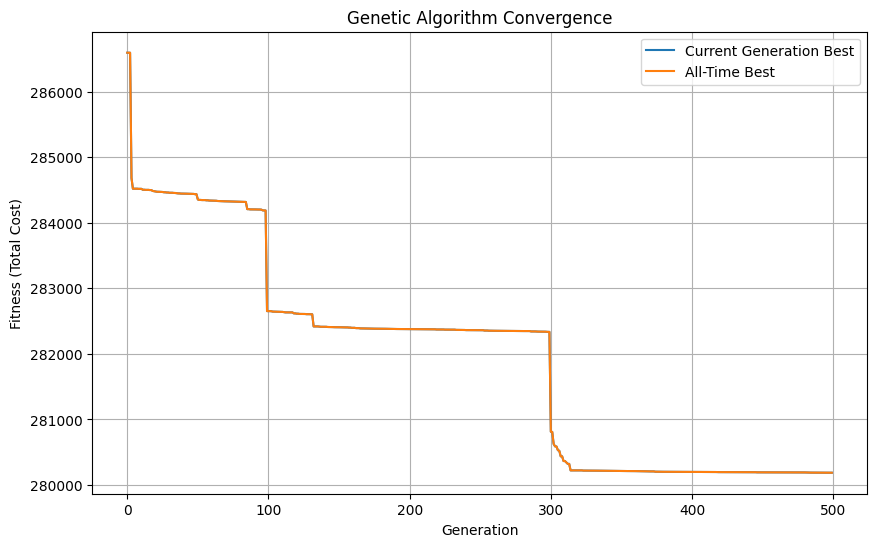

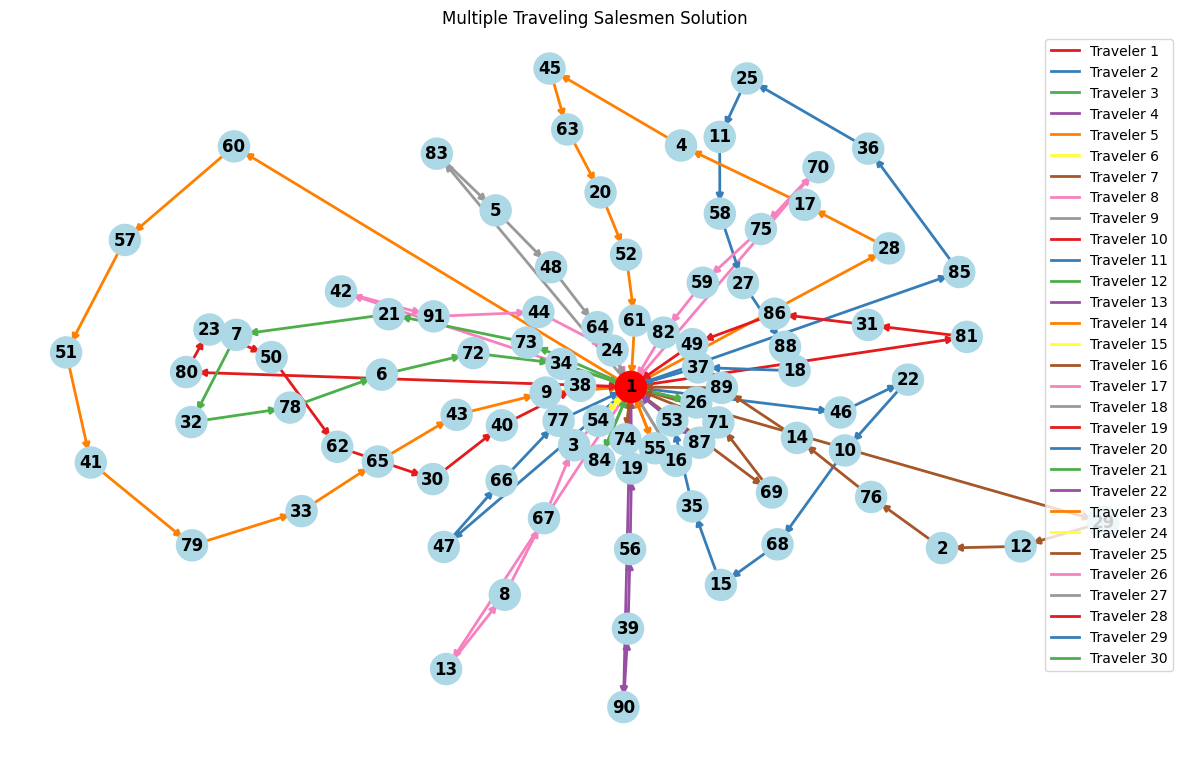

In [26]:
if __name__ == "__main__":
    v = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case3/vehicles.csv'
    c = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case3/clients.csv'
    d = 'C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case3/depots.csv'
    res = import_archives(v,c,d)
    cost_matrix = res[0]
    num_cities = len(cost_matrix)
    num_travelers = len(res[4].values())
    depots = [1]  # 1-indexed
    vehicle_r=res[2]
    demands = res[1]

    # Create and run the genetic algorithm
    ga = GeneticAlgorithmMTSP(
        cost_matrix=cost_matrix,
        num_cities=num_cities,
        num_travelers=num_travelers,
        demands=demands,
        vehicle_capacity = 130,
        vehicle_r=vehicle_r,
        depots=depots,
        population_size=500,
        generations=500,
        mutation_rate=0.25,
        crossover_rate=0.8,
        elitism_rate=0.02,
        tournament_size=5
    )

    # Solve the problem
    best_solution, best_fitness = ga.solve(verbose=True)

    # Print detailed solution
    print(ga.get_solution_details())

    # Plot results
    ga.plot_convergence()
    ga.plot_solution()

{('CD1', 'C1'): 10063.244131884807, ('CD1', 'C2'): 10065.158812070158, ('CD1', 'C3'): 10056.724150945074, ('CD1', 'C4'): 10065.562509648962, ('CD1', 'C5'): 10075.605162606107, ('CD1', 'C6'): 10070.861518752576, ('CD1', 'C7'): 10065.419362993542, ('CD1', 'C8'): 10049.853584044196, ('CD1', 'C9'): 10066.618530504387, ('CD1', 'C10'): 10058.848448766437, ('CD1', 'C11'): 10063.392579553058, ('CD1', 'C12'): 10059.022195438229, ('CD1', 'C13'): 10059.662721751407, ('CD1', 'C14'): 10058.380091094199, ('CD1', 'C15'): 10054.192770767502, ('CD1', 'C16'): 10055.619683319223, ('CD1', 'C17'): 10058.95884923408, ('CD1', 'C18'): 10053.730956370977, ('CD1', 'C19'): 10058.225229490054, ('CD1', 'C20'): 10060.452322740006, ('CD1', 'C21'): 10065.512784304241, ('CD1', 'C22'): 10052.473735230657, ('CD1', 'C23'): 10053.049081795652, ('CD1', 'C24'): 10055.79480383996, ('CD1', 'C25'): 10046.822715593546, ('CD1', 'C26'): 10061.499789310423, ('CD1', 'C27'): 10050.346212390006, ('CD1', 'C28'): 10057.804753135058, ('

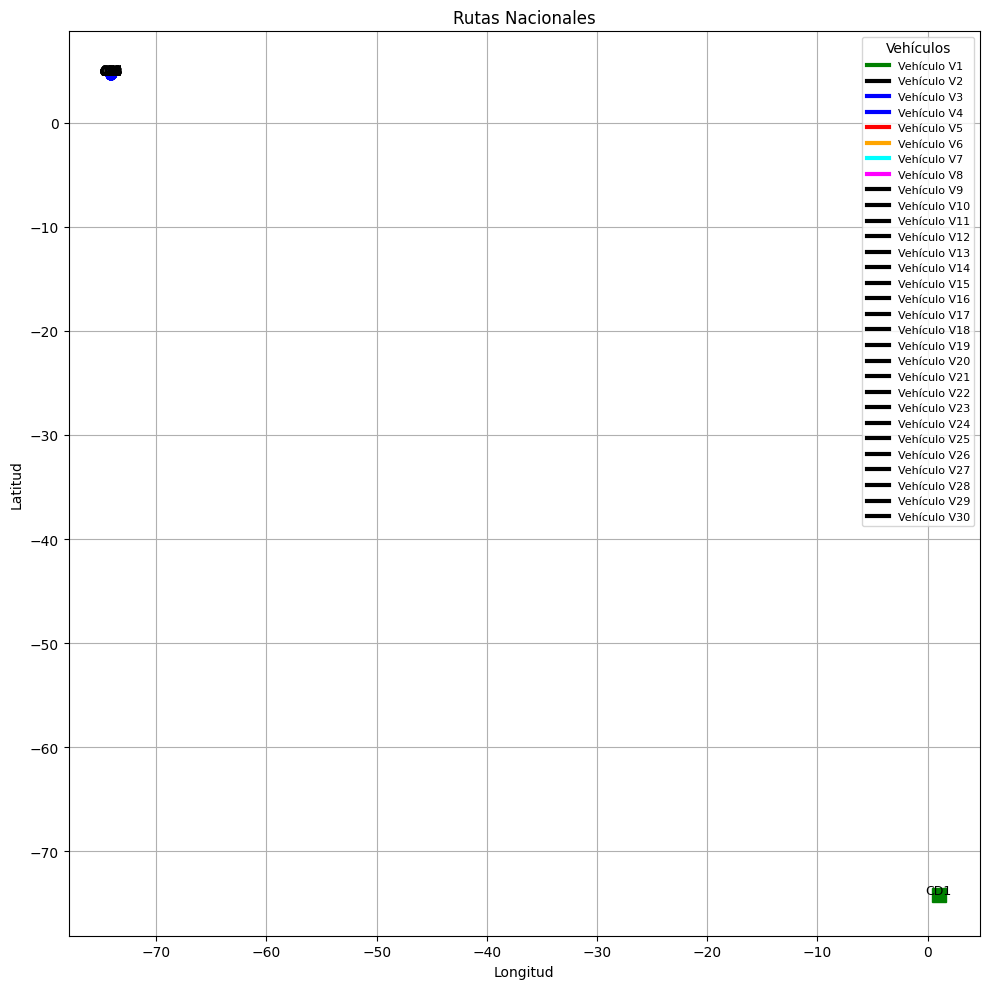

Mapa estático guardado en: ../visual-results/mapa_estatico_caso1.png


In [36]:
vehiculos = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case3/vehicles.csv')
municipios = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case3/clients.csv')
puertos = pd.read_csv('C:/Users/SebOg/OneDrive/Escritorio/Proyecto-C-MOS/data-cases/p3-case3/depots.csv')
puertos.rename(columns={"Latitude": "tmp", "Longitude": "Latitude", "DepotID": "Longitude", "LocationID": "DepotID"}, inplace=True)
puertos.drop(columns="tmp", inplace=True)

from IPython.display import display, HTML

puertos_f = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
    }
    for _, row in puertos.iterrows()
}

vehiculos_f = {
    f"V{int(row['VehicleID'])}": {
        "capacidad": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehiculos.iterrows()
}

municipios_f = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in municipios.iterrows()
}

parametros = {"fi": 12, "ft": 5000, "m": 700, "tk": 1}
distancias, geometries = calcular_distancias_y_geometrias(puertos_f, municipios_f, get_route_info)
print(distancias)
modelo2 = ModeloCasoBase(puertos_f, municipios_f, vehiculos_f, parametros, distancias)
modelo2.solve()
modelo2.print_routes()

colores1 = {
    'V1': 'green',
    'V2': 'black',
    'V3': 'blue',
    'V4': 'blue',
    'V5': 'red',
    'V6': 'orange',
    'V7': 'cyan',
    'V8': 'magenta',
}
visualizar_rutas_estatica(modelo2.model, puertos_f, municipios_f, geometries, colores1)

# **Calidad de la solución**
El valor de la función objetivo mide la eficiencia en la planificación de rutas y utilización de recursos. Pyomo garantiza una solución óptima cuando converge, asegurando la mejor asignación posible según el modelo matemático. La metaheurística, en cambio, encuentra soluciones aproximadas pero con una exploración más flexible del espacio de soluciones.

**Pyomo**: Soluciones exactas en instancias pequeñas y medianas.

**Metaheurística**: Soluciones subóptimas pero eficientes en problemas grandes.

**Tiempo de ejecución y recursos computacionales**
Pyomo requiere mayor capacidad computacional debido a la resolución exacta de modelos, mientras que la metaheurística puede ser parametrizada para reducir tiempos de cálculo.

**Pyomo**: Alto tiempo de ejecución con modelos grandes.

**Metaheurística**: Menor tiempo, optimizable por parámetros como tamaño de población y generación de soluciones.

# **Metaheurística vs Pyomo**

**Precisión**: Pyomo garantiza un óptimo si converge, mientras que GA (Metaheurística) ofrece una solución aproximada. Pyomo, al ser un enfoque determinista, enfrenta dificultades en instancias grandes debido a la complejidad computacional de la optimización exacta. En contraste, los métodos metaheurísticos pueden manejar mejor problemas de gran escala al explorar soluciones aproximadas con menor costo computacional.

**Flexibilidad:** Pyomo es difícil de adaptar dinámicamente, mientras que GA se adapta fácilmente a cambios.Pyomo sigue un modelo matemático rígido, lo que puede dificultar la adaptación a cambios dinámicos en restricciones o parámetros. Los metaheurísticos, por su naturaleza exploratoria, permiten ajustes más dinámicos en función de las condiciones del problema.

**Escalabilidad**: Pyomo tiene un rendimiento deficiente en instancias grandes, mientras que GA muestra un mejor comportamiento relativo.

**Tiempo de ejecución**: Pyomo tiene tiempos altos con modelos grandes, mientras que GA es más rápido si está bien parametrizado.

**Precisión vs. Eficiencia**: Pyomo garantiza soluciones óptimas si converge, lo que es ideal para problemas donde la precisión es crítica. Sin embargo, en problemas de gran escala, los metaheurísticos pueden ofrecer soluciones suficientemente buenas en menor tiempo, sacrificando precisión por eficiencia.


# **Evaluación de la escalabilidad del método metaheurístico implementado**
El método metaheurístico muestra una capacidad de adaptación superior a medida que las instancias del problema aumentan en tamaño. Gracias a su naturaleza basada en exploración y explotación de soluciones, tiende a mantener un rendimiento aceptable incluso en escenarios de gran escala. Sin embargo, la calidad de las soluciones depende significativamente de la calibración de los parámetros, lo que puede impactar la eficiencia y el tiempo de ejecución.

### **Análisis de la degradación de rendimiento**
A medida que el tamaño del problema crece, se observa una tendencia natural a la degradación del rendimiento debido al aumento en la complejidad de la búsqueda de soluciones óptimas. Factores como el número de variables, restricciones y la diversidad de soluciones posibles incrementan la carga computacional. Aunque los métodos metaheurísticos suelen ser más eficientes que los enfoques deterministas en grandes instancias, su rendimiento puede verse afectado por una parametrización deficiente o una convergencia prematura hacia soluciones subóptimas.